In [3]:
import sys
import pandas as pd
sys.path.append("/home/antonlee/github.com/tachyonicClock/SurpriseNetRun/SurpriseNet")
from study.study import vizier_client, vz, via_ssh

study_id = "S-PAMAP_LayerCount"

via_ssh()
client = vizier_client(
    owner="SurpriseNet",
    study_id=study_id
)
# client.delete()

In [4]:

trial_records = []
for trial in client.trials():
    trial = trial.materialize()


    trial_record = {}
    trial_record["feasible"] = trial._infeasibility_reason is None
    trial_record["length"] = trial.duration
    # trial_record["GitCommit"] = trial.metadata["GitCommit"]
    in_progress = trial.final_measurement is None

    # print(f"{trial.assigned_worker} {trial.metadata['ExperimentLabel']} {'Feasible' if trial_record['feasible'] else 'Infeasible'} {'IN_PROGRESS'if in_progress else 'DONE'}")

    for param_name, param in trial.parameters.items():
        trial_record[param_name] = float(param.value)


    if in_progress:
        continue
    for metric_name, metric in trial.final_measurement.metrics.items():
        trial_record[metric_name] = float(metric.value)

    trial_records.append(trial_record)

df = pd.DataFrame(trial_records)


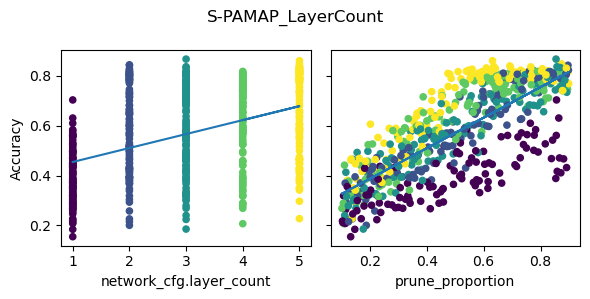

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import typing as t 

def plot_hyper_parameter(title: str,df: pd.DataFrame, independent_vars: t.List[str], dependent_var: str):
    fig, axis = plt.subplots(1, len(independent_vars), sharey=True, figsize=(len(independent_vars)*3, 3), tight_layout=True)

    for i, independent_var in enumerate(independent_vars):
        df.plot.scatter(x=independent_var, y=dependent_var, ax=axis[i], c=df["network_cfg.layer_count"])

        # # If learning rate use log x scale
        # if independent_var == "learning_rate":
        #     axis[i].set_xscale("log")
        
        try:
            feasible_points = df[df["feasible"] == True]
            x = feasible_points[independent_var]
            y = feasible_points[dependent_var]

            # Linear regression
            m, b = np.polyfit(x, y, 1)
            axis[i].plot(x, m*x + b)
        except Exception:
            pass



        axis[i].set_xlabel(independent_var)
        axis[i].set_ylabel(dependent_var)
    fig.suptitle(title)
zoom_tab = df[
    (df["Accuracy"] >= 0.75)
    # (df["network_cfg.layer_growth"] == 1.0) &
    # (df["network_cfg.width"] == 256) &
    # (df["network_cfg.dropout"] <= 0.2) &
    # (df["prune_proportion"] > 0.5) 
    # (df["latent_dims"] == 64)
]

plot_hyper_parameter(study_id, df, ["network_cfg.layer_count", "prune_proportion"], "Accuracy")
